# COMP47590: Advanced Machine Learning
# Assignment 1: Building Stacked Ensembles

Name(s): 

Student Number(s):

## Import Packages Etc

In [ ]:
from IPython.display import display, HTML, Image

from TAS_Python_Utilities import data_viz
from TAS_Python_Utilities import data_viz_target
from TAS_Python_Utilities import visualize_tree

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from random import randint
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.spatial import distance
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import KFold # import KFold

%matplotlib inline
#%qtconsole

## Define StackedEnsembleClassifier

Utility function to create classifer objects based on a name

In [ ]:
def create_classifier(classifier_type, tree_min_samples_split = 20):

    if classifier_type == "svm":
        c = svm.SVC(probability=True)

    elif classifier_type == "logreg":
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)

    elif classifier_type == "knn":
        c = neighbors.KNeighborsClassifier()

    elif classifier_type == "tree":
        c = tree.DecisionTreeClassifier(min_samples_split = tree_min_samples_split)

    elif classifier_type == "randomforest":
        c = ensemble.RandomForestClassifier()
        
    else:
        c = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=1000)
    
    return c

StackedEnsembleClassifier class.

In [ ]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedEnsembleClassifier(BaseEstimator, ClassifierMixin):

    # Constructor for the classifier object
    def __init__(self, base_estimator_types = ["svm", "logreg", "tree"], base_estimator_duplicates = 8, stack_layer_classifier_type = "logreg"):
     
        # Initialise class variabels
        self.base_estimator_types = base_estimator_types
        self.base_estimator_type_list = list()
        self.base_estimator_duplicates = base_estimator_duplicates
        self.stack_layer_classifier_type = stack_layer_classifier_type

    # The fit function to train a classifier
    def fit(self, X, y):
      
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        
        ########################
        # LEVEL 0
        ########################
        
        # Set up the base classifeirs in the ensemble
        self.classifiers_ = list()
        
        for i in range(0, self.base_estimator_duplicates):
            for t in self.base_estimator_types:

                self.base_estimator_type_list.append(t)      
                c = create_classifier(t, tree_min_samples_split=math.ceil(len(X)*0.05))
                self.classifiers_.append(c)
        
        # Store the number of classifers in the ensemble
        self.n_estimators_ = len(self.classifiers_)

        # Use all training data to train base classifiers
        X_train = X
        y_train = y
        
        # Set up empty arrays to hold stack layer training data
        self.X_stack_train = None #(dtype = float)
        self.y_stack_train = y_train
          
        # Train each base calssifier and generate the stack layer training dataset
        for classifier in self.classifiers_:

            # Extract a bootstrap sample
            X_train_samp, y_train_samp = resample(X_train, y_train, replace=True)    
            
            # Train a base classifier
            classifier.fit(X_train_samp, y_train_samp)
            
            # Make predictions for all instances in the training set
            y_pred = classifier.predict_proba(X_train)

            # Append the predictions ot the stack layer traing set (a bit of hacking here!)
            try:
                self.X_stack_train = np.c_[self.X_stack_train, y_pred]
            except ValueError:
                self.X_stack_train = y_pred
      
        ########################
        # LEVEL 1
        ########################
        
        # Create the stack layer classifier
        self.stack_layer_classifier_ = create_classifier(self.stack_layer_classifier_type, tree_min_samples_split=math.ceil(len(X)*0.05))

        # Train the stack layer using the newly created dataset
        self.stack_layer_classifier_.fit(self.X_stack_train, self.y_stack_train)
            
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
          
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
   
        X_stack_queries = None
              
        # Make a prediction with each base classifier and assemble the stack layer query
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
            
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred
        
        # Return the prediction made by the stack layer classifier
        return self.stack_layer_classifier_.predict(X_stack_queries)
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stack_layer_classifier_'])

        # Check that the input features match the type and shape of the training features
        X = check_array(X)
        
        X_stack_queries = None
        
        # Make a prediction with each base classifier
        for classifier in self.classifiers_:
            
            y_pred = classifier.predict_proba(X)
                
            try:
                X_stack_queries = np.c_[X_stack_queries, y_pred]
            except ValueError:
                X_stack_queries = y_pred

        # Return the prediction made by the stack layer classifier        
        return self.stack_layer_classifier_.predict_proba(X_stack_queries)

## Test the StackedEnsembleClassifier

Perform a simple test using the StackedEnsembleClassifier on the Iris dataset

In [44]:
sampling_rate = 0.1
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
Fashion_classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())
dataset["label"].value_counts()
if(dataset.select_dtypes(include=[np.number]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.number]).describe())
if(dataset.select_dtypes(include=[np.object]).shape[1] > 0):
    display(dataset.select_dtypes(include=[np.object]).describe())

X_data = dataset[dataset.columns[1:]]
Y_data = np.array(dataset["label"])

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
54239,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11287,0,0,0,0,0,0,0,2,0,0,...,199,216,81,0,2,0,0,0,0,0
34051,1,0,0,0,0,0,0,0,0,0,...,100,0,0,0,0,0,0,0,0,0
6175,2,0,0,0,0,0,0,0,0,0,...,0,2,0,10,123,124,23,0,0,0
5583,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000
mean,4.496833,0.000333,0.001333,0.029500,0.048000,0.214000,0.435667,0.797333,2.223833,5.623833,...,34.350167,23.155667,16.180500,17.646000,23.739167,19.042333,8.68600,2.638000,0.698167,0.020000
std,2.839484,0.018256,0.040806,1.021504,1.071239,3.585156,6.498325,7.619773,13.965573,23.513567,...,58.049119,49.215690,41.752207,43.926533,52.716800,46.449526,29.62526,17.003739,8.801305,1.058672
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55.000000,6.250000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,9.000000,1.000000,2.000000,78.000000,80.000000,133.000000,190.000000,195.000000,219.000000,237.000000,...,255.000000,255.000000,251.000000,248.000000,249.000000,242.000000,252.00000,255.000000,199.000000,81.000000


[ 426 ]  Dress


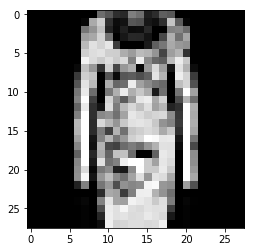

[ 637 ]  Bag


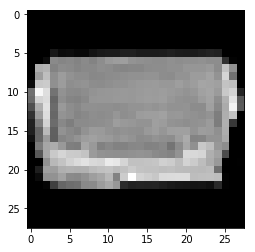

[ 704 ]  Bag


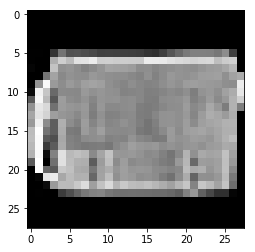

[ 743 ]  T-shirt/top


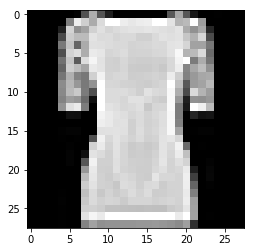

[ 623 ]  Pullover


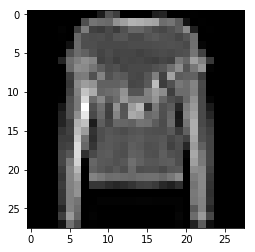

[ 592 ]  Sneaker


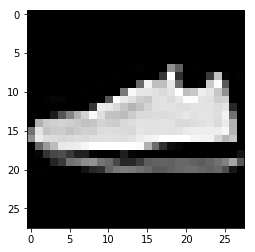

[ 774 ]  Sneaker


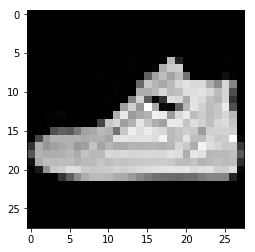

[ 359 ]  Dress


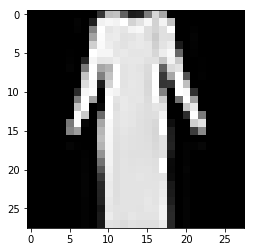

[ 305 ]  Shirt


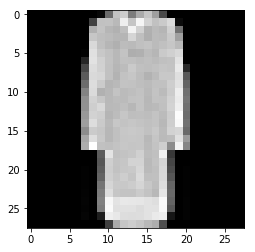

In [45]:
for i in range(0, 9):
    raniterm = randint(1, X_data.shape[1])

    print("[", raniterm, "] ", Fashion_classes[Y_data[raniterm]])
    selectedimg = (X_data.iloc[raniterm].values.reshape(28, 28))
    pyplot.imshow(selectedimg, cmap='gray')
    pyplot.show()
    X_data = X_data/255

In [46]:
clf = StackedEnsembleClassifier()
clf.fit(X_data, Y_data)
y_pred = clf.predict(X_data)
print(metrics.classification_report(Y_data, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(Y_data), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ericgyamfi/anaconda3/lib/python3.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       576
           1       0.00      0.00      0.00       596
           2       0.00      0.00      0.00       599
           3       0.00      0.00      0.00       596
           4       0.11      1.00      0.19       647
           5       0.00      0.00      0.00       608
           6       0.00      0.00      0.00       612
           7       0.00      0.00      0.00       613
           8       0.00      0.00      0.00       569
           9       0.00      0.00      0.00       584

   micro avg       0.11      0.11      0.11      6000
   macro avg       0.01      0.10      0.02      6000
weighted avg       0.01      0.11      0.02      6000

Confusion Matrix


/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Predicted,4,All
True,,
0,576,576
1,596,596
2,599,599
3,596,596
4,647,647
5,608,608
6,612,612
7,613,613
8,569,569


Perform a cross validation experiment

In [ ]:
scores = cross_val_score(clf, X_data, Y_data, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ericgyamfi/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ericgyamfi/anaconda3/lib/python3.

## Task 1: Design the StackedEnsembleHoldOut Class

In [ ]:
X_train_plus_valid, , y_train_plus_valid, y_test = train_test_split(X_data, Y_data, random_state=0, train_size = 0.7)

In [ ]:
clf = StackedEnsembleClassifier()
clf.fit(X_train_plus_valid, y_train_plus_valid)
y_pred_holdout = clf.predict(X_test)
print(metrics.classification_report(y_test, y_pred_holdout))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred_holdout, rownames=['True'], colnames=['Predicted'], margins=True))

In [ ]:
scores = cross_val_score(clf, X_train_plus_valid, y_train_plus_valid, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

## Task 2: Design the StackedEnsembleKFold Class

In [ ]:
# Write your code here
kf = KFold(n_splits=2) # Define the split - into 2 folds 
kf.get_n_splits(X_data)
print(kf)
KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf.split(X):    
    X_train, X_test_k_fold = X_data[train_index], X_data[test_index]
    y_train, y_test_k_fold = Y_data[train_index], Y_data[test_index]


In [ ]:
# Write your code here
clf = StackedEnsembleClassifier()
clf.fit(X_train, y_train)
y_pred_K_fold = clf.predict(X_test_k_fold)
print(metrics.classification_report(y_test_k_fold, y_pred_K_fold))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred_K_fold, rownames=['True'], colnames=['Predicted'], margins=True))


## Task 3: Compare the Performance of Different Stack Layer Approaches

In [ ]:
# Write your code here
accuracy = metrics.accuracy_score(Y_data, y_pred)
accuracy_holdout = metrics.accuracy_score(y_test, y_pred_K_fold)
accuracy_K_Fold = metrics.accuracy_score(y_test_k_fold, y_pred_holdout)
print("Classifier Accuracy: "+ str(accuracy))
print("HoldOut Accuracy: "+ str(accuracy_holdout))
print("K-Fold Accuracy: "+ str(accuracy_K_Fold))

## Task 4: Comparing the Performance of Different Stack Layer Approaches with  More Standard Approaches

In [ ]:
# Write your code here
New_tree = tree.DecisionTreeClassifier(criterion="entropy")
New_tree.fit(X_train,y_train)
y_pred_tree = New_tree.predict(X_test)

accuracy_tree = metrics.accuracy_score(y_test, y_pred_tree)
model_valid_accuracy_comparisons["Better Tree"] = accuracy
print("Tree Accuracy: " +  str(accuracy_tree))
print(metrics.classification_report(y_valid, y_pred_tree))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred_tree, rownames=['True'], colnames=['Predicted'], margins=True))

In [ ]:
## Bagging classifier

In [ ]:
logreg = BaggingClassifier(New_tree, max_samples=0.5, max_features=0.5)
logreg.fit(X_train,y_train)
y_pred_bagging = logreg.predict(X_test)

accuracy_bagging = metrics.accuracy_score(y_test, y_pred_bagging)
model_valid_accuracy_comparisons["Better Tree"] = accuracy_bagging
print("Bagging Accuracy: " +  str(accuracy_bagging))
print(metrics.classification_report(y_valid, y_pred_bagging))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred_bagging, rownames=['True'], colnames=['Predicted'], margins=True))

In [ ]:
## Grid Search

In [ ]:
Grid_search_tree = tree.DecisionTreeClassifier(max_depth = 12)
results = cross_val_score(Grid_search_tree, X_train_plus_valid, y_train_plus_valid, cv=5)
print(results)
param_grid ={'criterion': ['gini', "entropy"], 'max_depth': list(range(3, 50, 3)), 'min_samples_split': [200]}

# Grid search
grid_tuned_tree = GridSearchCV(tree.DecisionTreeClassifier(), param_grid, cv=cv_folds, verbose = 2, return_train_score=True)
grid_tuned_tree.fit(X_train_plus_valid, y_train_plus_valid)

# Print details
print("best performing parameters set:")
#display(grid_tuned_tree.best_params_)
model_tuned_params_list["Tuned Tree"] = grid_tuned_tree.best_params_
y_pred = grid_tuned_tree.predict(X_test)

accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
model_test_accuracy_comparisons["Tuned Tree"] = accuracy
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

print("Confusion Matrix")
mat = confusion_matrix(np.array(y_test), y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,xticklabels=Fashion_classes,yticklabels=Fashion_classes)
plt.xlabel('true label')
plt.ylabel('predicted label');

## Task 5: Implement the StackedEnsembleOneVsOne Class

In [ ]:
# Write your code here
model = OneVsOneClassifier(Fashion_classes, n_jobs=None)
onevsone = BaggingClassifier(model, max_samples=0.5, max_features=0.5)
onevsone.fit(X_train,y_train)
y_pred_onevsone = onevsone.predict(X_test)

accuracy_onevsone = metrics.accuracy_score(y_test, y_pred_onevsone)
model_valid_accuracy_comparisons["Better Tree"] = accuracy_onevsone
print("One-Vs-One Accuracy: " +  str(accuracy_onevsone))
print(metrics.classification_report(y_valid, y_pred_onevsone))
print("Confusion Matrix")
display(pd.crosstab(np.array(y_train), y_pred_onevsone, rownames=['True'], colnames=['Predicted'], margins=True))

## Task 6 Evaluate the Performance of the StackedEnsembleCalassifierOneVsOne Algorithm

In [ ]:
# Write your code here


## Task 7 Reflect on the Performance of the Different Models Evaluated

In [ ]:
"""
The Stack ensembling method used in all the methods above have different results. Each of them also have different 
training time. The result obtained from the stacked ensemble class based on the HoldOut has good performance and the
training time is also shorter compared with the other methods. Mosth of the the other methods have long training time 
based on the underlying algorithms. Using hetrogenuos method in the ensembling provided better results as seen from 
the above but they have long running time during their training.
"""


*Write your reflection here (max 300 words)*